In [1]:
 import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow


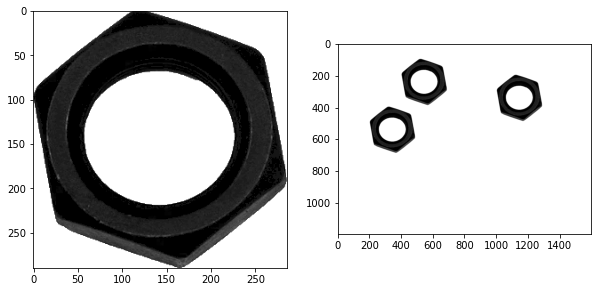

In [2]:
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
belt_im = cv.imread(r'belt.png', cv.IMREAD_GRAYSCALE)
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

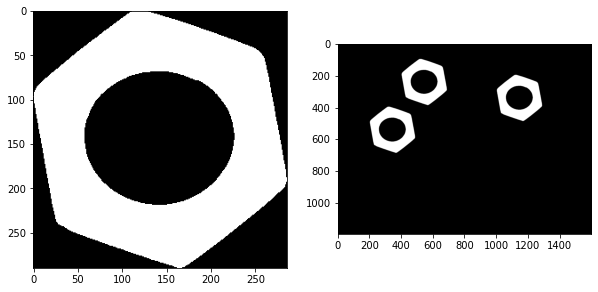

In [3]:
th_a, img_a = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(img_a, cmap='gray')
ax[1].imshow(img_b, cmap='gray')
plt.show()

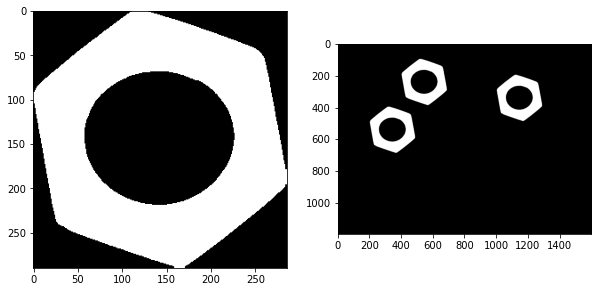

In [4]:
kernel = np.ones((3,3),np.uint8)
closing_a = cv.morphologyEx(img_a, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(closing_a, cmap='gray')
ax[1].imshow(closing_b, cmap='gray')
plt.show()

In [42]:
retval_a, labels_a, stats_a, centroids_a = cv.connectedComponentsWithStats(closing_a)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)


contours_a, hierarchy_a = cv.findContours(closing_a, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(len(contours_b))


6


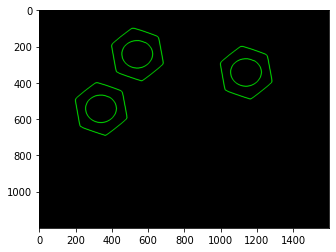

In [15]:
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)


In [18]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for j,c in enumerate(belt_cont):
  print(cv.matchShapes(contours_a[0], c, cv.CONTOURS_MATCH_I1, 0.0))


0.00010071698397173812
0.00010071698397950968
0.00010071698397506879


# Part - II

In [19]:
ca = cv.contourArea(contours_b[1])
M = cv.moments(contours_b[1])
print(ca)
print(M)
cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00']) 
print("Centroid coordinates", (cx, cy))

20080.0
{'m00': 20080.0, 'm10': 6857249.333333333, 'm01': 10902219.5, 'm20': 2377821838.6666665, 'm11': 3722971235.5, 'm02': 5947774212.166666, 'm30': 836677775088.6001, 'm21': 1290927450455.1833, 'm12': 2031031745454.1167, 'm03': 3260276110202.5503, 'mu20': 36095323.75130558, 'mu11': -98356.04525279999, 'mu02': 28531680.98238945, 'mu30': 7133283.688598633, 'mu21': -18102990.339790344, 'mu12': -5413550.269262314, 'mu03': 14292721.049316406, 'nu20': 0.08952071135603398, 'nu11': -0.00024393473231774097, 'nu02': 0.07076197446863307, 'nu30': 0.00012484760770737689, 'nu21': -0.00031684076155347586, 'nu12': -9.474862206886426e-05, 'nu03': 0.0002501529601981355}
Centroid coordinates (341, 542)


In [20]:
count = 1
object_prev_frame = np.array([cx, cy, ca, count])
delta_x = 15
print(object_prev_frame)

[3.410e+02 5.420e+02 2.008e+04 1.000e+00]


# Part - III

In [21]:
def get_indexed_image(image):
  thres, img = cv.threshold(image,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
  kernel = np.ones((3,3),np.uint8)
  closing_img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
  retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing_img)
  return retval, labels, stats, centroids

In [22]:
 def is_new(a, b, delta, i):
   for j in range(len(a)):
     G = abs(a[j][i] - b[i])
     if G < delta:
       return False
       break
   else:
     return True


In [23]:
 # check is_new expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
print(is_new(a, b, delta, i))
assert is_new(a, b, delta, i) == False, " Check the function "

False


In [24]:
 def prev_index(a, b, delta, i):
   index = -1
   for j in range(len(a)):
     G = abs(a[j][i] - b[i])
     if G < delta:
       return j
   else:
     return index

In [25]:
 # check prev_index expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
print(prev_index(a,b,delta,i))
assert prev_index(a,b,delta,i) == 1, " Check the function "


1


In [28]:
cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    print("Can't receive frame (stream end?). Exiting ...")
    break
  
  gray_img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) 
  retval, labels, stats, centroids=get_indexed_image(gray_img) 
  belt_img = ((labels >= 1)*255).astype('uint8')
  belt_cont_img, template_hierarchy = cv.findContours(belt_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) 
  im_contours_belt_img = np.zeros((frame.shape[0],frame.shape[1],3), np.uint8)                        
  conts = cv.drawContours(im_contours_belt_img, belt_cont_img, -1, (0,255,0), 3).astype('uint8')      
  cv.namedWindow("frame of a video", cv.WINDOW_NORMAL) 
  cv.imshow("frame of a video",conts)                                                            
  if cv.waitKey(1) == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

In [41]:
retval_a, labels_a, stats_a, centroids_a = get_indexed_image(template_im)
belt_a = ((labels_a >= 1)*255).astype('uint8')
belt_a_cont, template_a_hierarchy = cv.findContours(belt_a, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cap = cv.VideoCapture('conveyor_with_rotation.mp4')
video_out = cv.VideoWriter('180265N.mp4', -1 , 20.0, (1920,1080))
nuts_detail=np.array([])                         
delta = 15   
frame_num=0                                                                           



while cap.isOpened():
    ret, frame = cap.read() 
    frame_num+=1            
    gap=0                
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    gray=cv.cvtColor(frame, cv.COLOR_BGR2GRAY)                                                      
    retval, labels, stats, centroids=get_indexed_image(gray)                                        
    belt = ((labels >= 1)*255).astype('uint8')
    belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) 

 
    for cont in belt_cont:
        text="" 
        if cv.matchShapes(belt_a_cont[0], cont, cv.CONTOURS_MATCH_I1, 0.0)>0.0008:
            continue
        
        ca = cv.contourArea(cont)
        M = cv.moments(cont)
        if M['m00']==0:
            continue
        cx, cy = int(M['m10']/M['m00']) , int(M['m01']/M['m00'])
        count = 1 
        object_cur_frame = np.array([cx, cy, ca, count])


        if nuts_detail.shape[0]==0:       
            nuts_detail=(np.append(nuts_detail,object_cur_frame)).reshape((1,4))
            index=nuts_detail.shape[0]-1  

        elif is_new(nuts_detail, object_cur_frame, delta, 0):                    
            nuts_detail=np.concatenate((nuts_detail,np.array([object_cur_frame])),axis=0)  
            index=nuts_detail.shape[0]-1                                          
        else:
            index=prev_index(nuts_detail, object_cur_frame, delta, 0)   
            nuts_detail[index]=object_cur_frame                         

        font = cv.FONT_HERSHEY_SIMPLEX
        cv.putText(frame,str(index+1),(cx,cy), font, 2,(255,0,255),2,cv.LINE_AA)
        text+="Object "+str(index+1)+" "+str(nuts_detail[index,0])+", "+str(nuts_detail[index,1])+", "+str(nuts_detail[index,2])
        cv.putText(frame,text,(50,1050-gap), font, 1.5,(255,0,255),2,cv.LINE_AA)
        gap+=75
        
    
    cv.putText(frame,"Frame "+str(frame_num),(50,1050-gap), font, 1.5,(0,255,0),2,cv.LINE_AA) 
    Contour= cv.drawContours(frame, belt_cont, -1, (0,255,0), 3).astype('uint8')                              
    cv.namedWindow("frame", cv.WINDOW_NORMAL) 
    cv.imshow("frame",Contour)
    video_out.write(Contour)
     
    if cv.waitKey(1) == ord('q'):
        break
cap.release()
video_out.release()
cv.destroyAllWindows()